# Circuit function analytics: Stats summarizing behavior (precision, sensitivity, response time...)

To assess the functional characteristics of a genetic circuit, there are several important analytics that are collected. Here the validity of their calculation is demonstrated across a set of test cases.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

from functools import partial
import numpy as np
import pandas as pd
import jax.numpy as jnp
import jax
jax.config.update('jax_platform_name', 'cpu')
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import bioreaction
from bioreaction.simulation.med_sim import get_int_med_model, MedSimParams, MedSimInternalState


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from synbio_morpher.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics
from synbio_morpher.utils.results.analytics.timeseries import generate_analytics
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.signal.signals_new import SignalFuncs

In [3]:

def update_model_rates(model, a=None, d=None, ka=None, kd=None):
    for i, r in enumerate(model.reactions):
        if not r.input:  # 0 -> RNA
            if a is not None:
                model.reactions[i].forward_rate = a[model.species.index(
                    r.output[0])]
                model.reactions[i].reverse_rate = 0
        elif not r.output:  # RNA -> 0
            if d is not None:
                model.reactions[i].forward_rate = d[model.species.index(
                    r.input[0])]
                model.reactions[i].reverse_rate = 0
        else:
            if ka is not None:
                model.reactions[i].forward_rate = ka[model.species.index(r.input[0]),
                                                    model.species.index(r.input[1])]
            if kd is not None:
                model.reactions[i].reverse_rate = kd[model.species.index(r.input[0]),
                                                    model.species.index(r.input[1])]
    return model


### Define parameters

A model with three nodes (three interacting RNA molecules) will be generated, where the first RNA acts as the input or signal node.

In [4]:
num_species = 3
input_species_idx = 0
output_species_idx = 1


med_model = bioreaction.templates.generate_rnabinding_medsim(
    num_species=num_species,
    a=np.ones(num_species), d=np.ones(num_species**2), 
    ka=np.ones((num_species, num_species)),
    kd=np.ones((num_species, num_species)),
    impulse_idx=input_species_idx
)

Keq = np.array(
    [[1, 2, 1],
     [2, 1, 0.5],
     [1, 0.5, 2]]
)
# From src/utils/common/configs/RNA_circuit/molecular_params.json
a=np.ones(num_species) * 0.08333
d=np.ones(len(med_model.species)) * 0.0008333
ka=np.ones_like(Keq)
kd=ka/Keq

med_model = update_model_rates(med_model, a=a, d=d, ka=ka, kd=kd)

t0 = 0 
t1 = 100
dt0 = 0.1
t = np.arange(t0, t1/dt0) * dt0
t_sig = t1/2
target = 100
baseline = 120
overshoot = 10
overshoot_height = target + 10

In [5]:

s0 = np.concatenate([np.array([1.0, 1.0, 1.0]), np.zeros(len(med_model.species[num_species:]))])

# impulse = Impulse(target=med_model.species[:num_species][input_species_idx], delta_target=20, time=100.0, impulse_width=0.0)
med_model.impulses = []
poiss_simmed = jnp.zeros(len(med_model.reactions))
brown_simmed = jnp.zeros(len(med_model.reactions))

# Making the params for the simulation, how things are simutated and for how long.
int_med_params = MedSimParams(delta_t= 0.01, t_start=0.0, t_end = 1000.0, poisson_sim_reactions=poiss_simmed, brownian_sim_reaction=brown_simmed)
int_med_model = get_int_med_model(med_model)
int_med_state = MedSimInternalState(concentrations=s0, other_factors=jnp.zeros(len(med_model.other_factors)))

### Make some fake signals

Four types of signal responses will be tested. The first matches the classic step input. Next is the step function with a small overshoot, then a 'perfectly adapting' function with an overshoot that adjusts back to the original pre-input level. Finally, the last response has an undershoot before adjusting to the final level of the input.

Text(0.5, 0.98, 'Toy input signals')

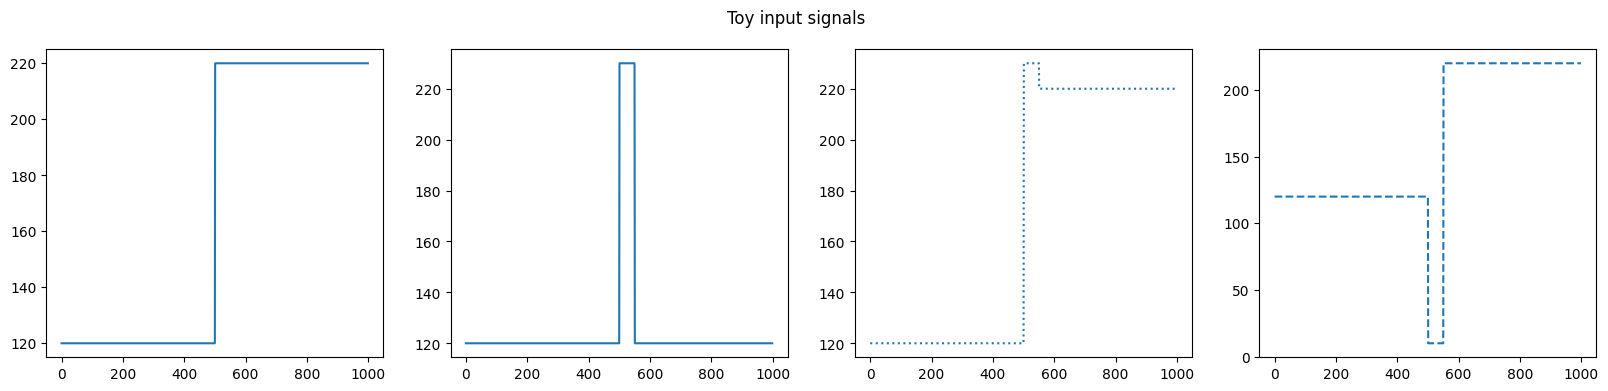

In [6]:
i = 0
plt.figure(figsize=(20, 4))
ax = plt.subplot(1,4,1)
plt.plot(np.array(SignalFuncs.step_function_integrated(t, t_sig + i, target=target + i)) + baseline)
ax = plt.subplot(1,4,2)
plt.plot(SignalFuncs.step_function_integrated(t, t_sig + i, target=overshoot_height + i) - 
         SignalFuncs.step_function_integrated(t, t_sig + i + overshoot/2, target=overshoot_height + i) + baseline)
ax = plt.subplot(1,4,3)
plt.plot(SignalFuncs.step_function_integrated(t, t_sig + i, target=target + i) + 
         SignalFuncs.step_function_integrated(t, t_sig + i, target=overshoot + i) - 
         SignalFuncs.step_function_integrated(t, t_sig + i + overshoot/2, target=overshoot + i) + baseline, ':')

ax = plt.subplot(1,4,4)
plt.plot(
    SignalFuncs.step_function_integrated(t, t_sig + i, target=- (overshoot_height + i)) +
    SignalFuncs.step_function_integrated(t, t_sig + i + overshoot/2, target= 2 * target + overshoot + i) + baseline,
    '--'
)
plt.suptitle('Toy input signals')

Creating fake traces from toy signals:

In [13]:

signal_onehot = 1 * \
    np.array([f == med_model.species[input_species_idx]
             for f in med_model.species])

def get_lags(n):
    lags = list(np.arange(n) + overshoot/2)
    lags[input_species_idx] = 0
    lags[2] = 2
    lags[3] = np.inf
    return lags

lags = get_lags(len(med_model.species))

data = np.asarray([
    SignalFuncs.step_function_integrated(t, t_sig + i, target=target + i) +
    SignalFuncs.step_function_integrated(t, t_sig + i, target=overshoot) -
    SignalFuncs.step_function_integrated(t, t_sig + i + overshoot/2, target=overshoot) for i in range(len(med_model.species))]) + baseline
data[input_species_idx] = np.array(
    SignalFuncs.step_function_integrated(t, t_sig, target=target)) + baseline
data[2] = np.array(SignalFuncs.step_function_integrated(
    t, t_sig + 2, target=target + 2)) + baseline
data[3] = baseline
data[4] = np.asarray(
    SignalFuncs.step_function_integrated(t, t_sig + 4, target=- (overshoot_height + 4)) +
    SignalFuncs.step_function_integrated(t, t_sig + 4 + overshoot/2, target= 2 * target + overshoot + 4)) + baseline

ref_circuit_data = np.asarray([
    SignalFuncs.step_function_integrated(t, t_sig + i * 2, target=target + i * 2) +
    SignalFuncs.step_function_integrated(t, t_sig + i * 2, target=overshoot) -
    SignalFuncs.step_function_integrated(t, t_sig + i * 2 + overshoot/2, target=overshoot) for i in range(len(med_model.species))]) + baseline
ref_circuit_data[input_species_idx] = np.array(
    SignalFuncs.step_function_integrated(t, t_sig, target=target)) + baseline
ref_circuit_data[2] = np.array(
    SignalFuncs.step_function_integrated(t, t_sig + 2, target=target + 2)) + baseline
ref_circuit_data[3] = baseline
ref_circuit_data[4] = np.asarray(
    SignalFuncs.step_function_integrated(t, t_sig + 4 * 2, target=- (overshoot_height + 4 * 2)) +
    SignalFuncs.step_function_integrated(t, t_sig + 4 * 2 + overshoot/2, target= 2 * target + overshoot +  4 * 2)) + baseline

signal_onehot_expanded = (np.ones_like(
    data) * np.expand_dims(signal_onehot, axis=1))
data_sig_rev = data * (signal_onehot_expanded == 0)*1 + ((data[input_species_idx].max(
    ) + data[input_species_idx].min()) - data) * signal_onehot_expanded
ref_circuit_data_sig_rev = ref_circuit_data * (signal_onehot_expanded == 0)*1 + ((ref_circuit_data[input_species_idx].max(
    ) + ref_circuit_data[input_species_idx].min()) - ref_circuit_data) * signal_onehot_expanded

batch_data = np.concatenate(np.expand_dims([
    data,
    (data.max() + data.min()) - data,
    data_sig_rev,
    (data_sig_rev.max() + data_sig_rev.min()) - data_sig_rev
    # data_rev * (signal_onehot_expanded == 0)*1 + data * signal_onehot_expanded,
], axis=0), axis=0
)
batch_ref_data = np.concatenate(np.expand_dims([
    ref_circuit_data,
    (ref_circuit_data.max() + ref_circuit_data.min()) - ref_circuit_data,
    ref_circuit_data_sig_rev,
    (ref_circuit_data_sig_rev.max() + ref_circuit_data_sig_rev.min()) - ref_circuit_data_sig_rev,
], axis=0), axis=0
)

vmap_gen_analytics = jax.vmap(partial(generate_analytics, time=t, labels=med_model.species,
                                      signal_onehot=signal_onehot,
                                      signal_time=t_sig))
vv = vmap_gen_analytics(batch_data, ref_circuit_data=batch_ref_data)
analytics = {k: np.array(v) for k, v in
             vv.items()
             }


Total time: 0:00:00.015587
Full timings:
 {'init': 0.00019246808237633926, 'initial_steady_states': 0.06582408417270802, 'max_amount': 0.027330467697440176, 'min_amount': 0.022582921665490474, 'steady_states': 0.060948226085840766, 'RMSE': 0.10220055174183615, 'first_derivative': 0.019182652210175146, 'fold_change': 0.05722717649323154, 'overshoot': 0.016488099056906395, 'precision_wrt_species-0': 0.2493744787322769, 'response_time_wrt_species-0': 0.17354205427599922, 'sensitivity_wrt_species-0': 0.20510681978571887}
Total time: 0:00:00.015325
Full timings:
 {'init': 6.525285481239805e-05, 'initial_steady_states': 0.0698858075040783, 'max_amount': 0.024208809135399675, 'min_amount': 0.02264274061990212, 'steady_states': 0.05931484502446982, 'RMSE': 0.10257748776508972, 'first_derivative': 0.0200326264274062, 'fold_change': 0.05644371941272431, 'overshoot': 0.0166394779771615, 'precision_wrt_species-0': 0.2469820554649266, 'response_time_wrt_species-0': 0.17709624796084827, 'sensitivity

IndexError: tuple index out of range

In [14]:


def get_peaks(initial_steady_states, final_steady_states, maxa, mina):
    return jnp.where(
        initial_steady_states < final_steady_states,
        maxa - mina + initial_steady_states,
        mina - maxa + initial_steady_states
    )


def calculate_precision(output_diff, starting_states, signal_diff, signal_0) -> jnp.ndarray:
    denom = jnp.where(signal_0 != 0, signal_diff / signal_0, 1)
    numer = jnp.where((starting_states != 0).astype(int),
                      output_diff / starting_states, 1)
    precision = jnp.absolute(jnp.divide(
        numer, denom))
    return jnp.divide(1, precision)


def get_precision(signal_idx: int, starting_states, steady_states):
    if signal_idx is None:
        return None
    signal_0 = starting_states[signal_idx]
    signal_1 = steady_states[signal_idx]

    signal_diff = signal_1 - signal_0
    output_diff = steady_states - starting_states

    return calculate_precision(output_diff, starting_states, signal_diff, signal_0)


def calculate_sensitivity(output_diff, starting_states, signal_diff, signal_0) -> jnp.ndarray:
    denom = jnp.where(signal_0 != 0, signal_diff / signal_0, np.inf)
    numer = jnp.where((starting_states != 0).astype(int),
                      output_diff / starting_states, np.inf)
    return jnp.absolute(jnp.divide(
        numer, denom))


def get_sensitivity(signal_idx: int, starting_states, peaks):
    if signal_idx is None:
        return None
    signal_1 = peaks[signal_idx]
    signal_0 = starting_states[signal_idx]

    output_diff = peaks - starting_states
    signal_diff = signal_1 - signal_0

    return calculate_sensitivity(output_diff, starting_states, signal_diff, signal_0)


### Process analytics

Now that we have fake signals, what are the summary analytics that we get from them? Are they accurate? We will mainly look at things like the response time, sensitivity, and precision.

In [15]:
analytics_types = get_analytics_types_all()
analytics_types = [k for k in get_true_names_analytics(analytics) if [kk for kk in analytics_types if kk in k]]

In [16]:
for k in analytics_types:
    # for i in range(batch_data.shape[0]):
    analytics[k] = np.squeeze(np.concatenate(analytics[k]))

analytics['data_index'] = np.repeat(np.arange(batch_data.shape[0]), repeats=data.shape[0])
analytics['species_index'] = flatten_listlike([med_model.species for i in range(batch_data.shape[0])])

In [17]:
analytics_df = pd.DataFrame.from_dict({k: analytics[k] for k in ['data_index', 'species_index'] + sorted(analytics_types)})

analytics_df['data_category'] = ''
data_category = {0: 'Signal up: same response', 
                 1: 'Signal down: same response', 
                 2: 'Signal up: inverse response',
                 3: 'Signal down: inverse response'}
for i in range(batch_data.shape[0]):
    analytics_df.loc[analytics_df['data_index'] == i, 'data_category'] = data_category[i]
analytics_df.head()

,data_index,species_index,RMSE,RMSE_diff_to_base_circuit,RMSE_ratio_from_mutation_to_base,fold_change,fold_change_diff_to_base_circuit,fold_change_ratio_from_mutation_to_base,initial_steady_states,initial_steady_states_diff_to_base_circuit,...,response_time_wrt_species-0,response_time_wrt_species-0_diff_to_base_circuit,response_time_wrt_species-0_ratio_from_mutation_to_base,sensitivity_wrt_species-0,sensitivity_wrt_species-0_diff_to_base_circuit,sensitivity_wrt_species-0_ratio_from_mutation_to_base,steady_states,steady_states_diff_to_base_circuit,steady_states_ratio_from_mutation_to_base,data_category
0,0,Species: RNA 0,0.000000,0.000000,inf,1.833333,0.000000,1.000000,120,0,...,0.0,0.0,inf,1.00,0.00,1.000000,220,0,1.000000,Signal up: same response
1,0,Species: RNA 1,11.175375,11.175375,inf,1.841667,-0.008333,0.995495,120,0,...,6.0,-1.0,0.857143,1.11,-0.01,0.991071,221,-1,0.995495,Signal up: same response
2,0,Species: RNA 2,0.000000,0.000000,inf,1.850000,0.000000,1.000000,120,0,...,2.0,0.0,1.000000,1.02,0.00,1.000000,222,0,1.000000,Signal up: same response
3,0,Species: RNA 0-0,0.000000,0.000000,inf,1.000000,0.000000,1.000000,120,0,...,inf,NaN,NaN,0.00,0.00,inf,120,0,1.000000,Signal up: same response
4,0,Species: RNA 0-1,49.203255,49.203255,inf,1.833333,0.000000,1.000000,120,0,...,9.0,-4.0,0.692308,2.14,-0.04,0.981651,220,0,1.000000,Signal up: same response


### Graph signal input and responses

1st row: Signal response in the same direction
2nd row: Signal respones in the inverse direction


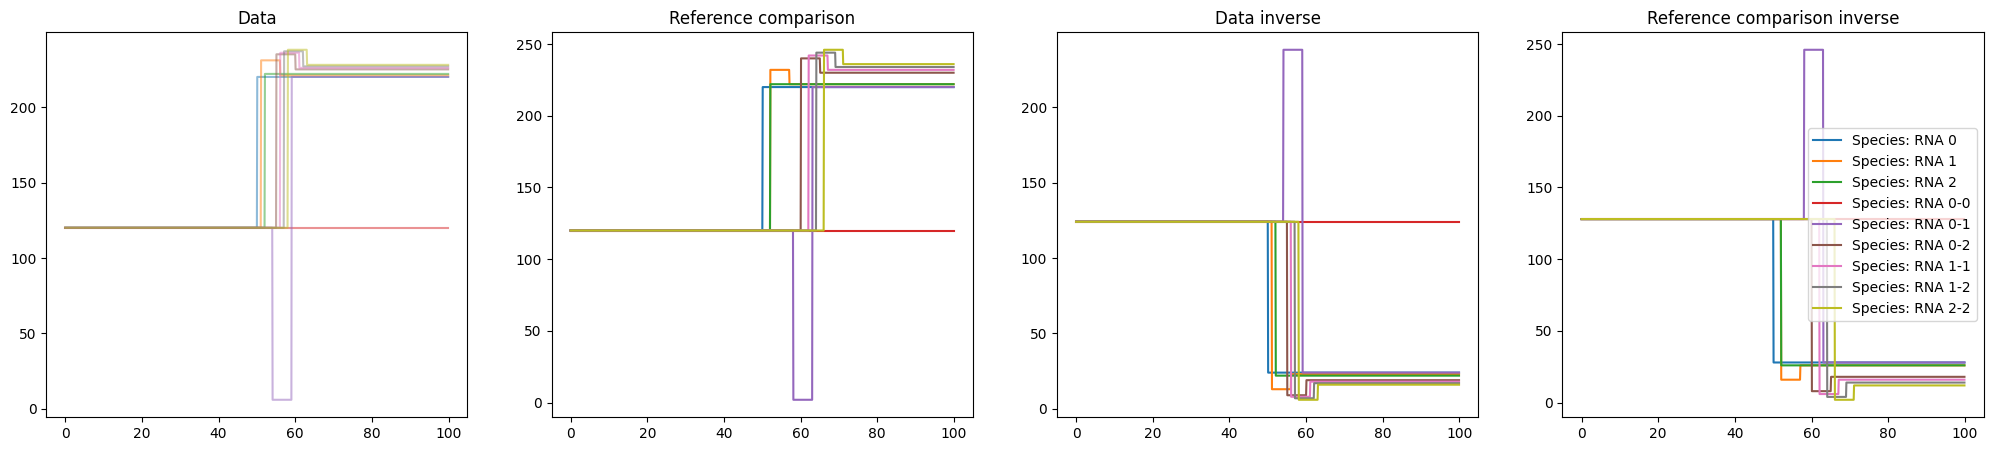

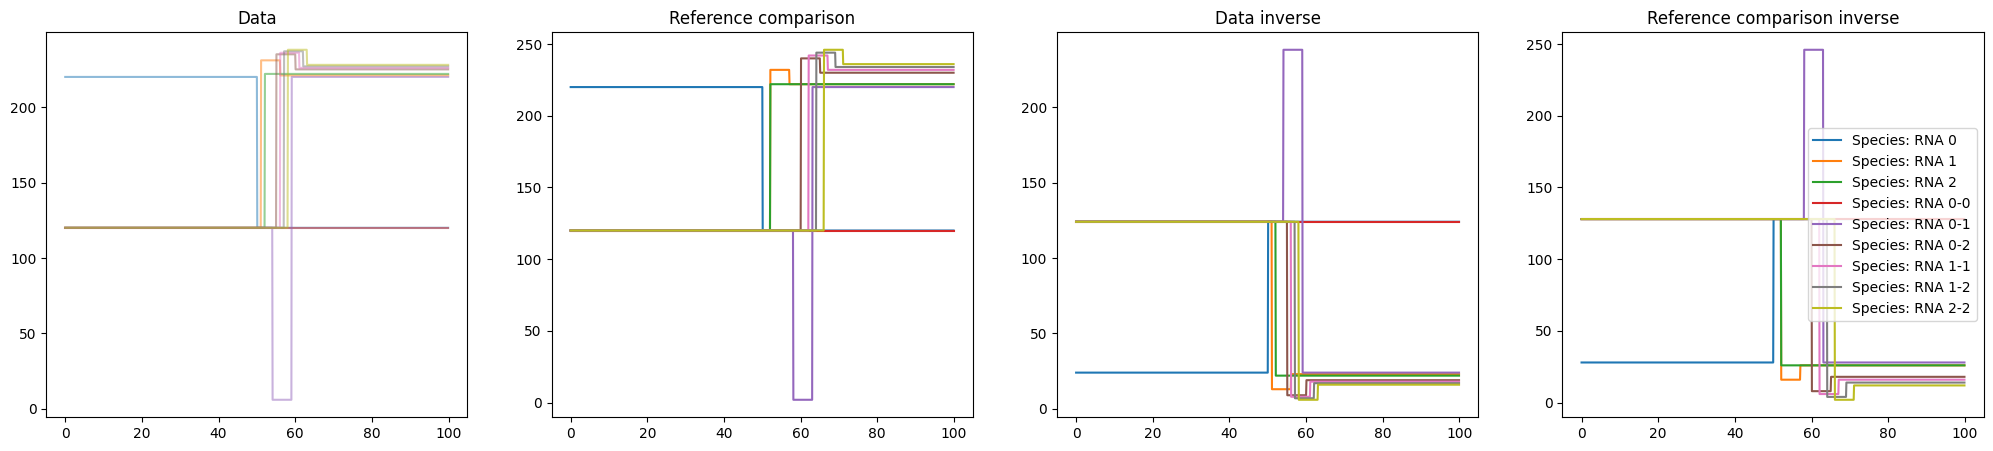

In [18]:
for i in [0, 2]:
    if i == 0:
        print('1st row: Signal response in the same direction')
    else:
        print('2nd row: Signal respones in the inverse direction')
    plt.figure(figsize=(25,5))
    ax = plt.subplot(1,4,1)
    plt.plot(t, np.swapaxes(batch_data[i], 0, 1), alpha=0.5)
    plt.title('Data')
    ax = plt.subplot(1,4,2)
    plt.plot(t, np.swapaxes(batch_ref_data[i], 0, 1))
    plt.title('Reference comparison')
    ax = plt.subplot(1,4,3)
    plt.plot(t, np.swapaxes(batch_data[i+1], 0, 1))
    plt.title('Data inverse')
    ax = plt.subplot(1,4,4)
    plt.plot(t, np.swapaxes(batch_ref_data[i+1], 0, 1))
    plt.title('Reference comparison inverse')
    plt.legend(med_model.species)


# Examining analytics from data

There are four possible ways a system can behave with a signal. The signal can be a rising or falling step function and the system's response may also be rising or falling. The precision, sensitivity, overshoot and time response must all be invariant to this. 

$$ Sensitivity = | \frac{(O_{peak} - O_1) / O_1}{(I_2 - I_1) / I_1} |$$

$$ Precision =  | \frac{(O_2 - O1)/O_1}{(I_2 - I_1) / I_1} |^{-1} $$

Precision and sensitivity - same for inverse response.

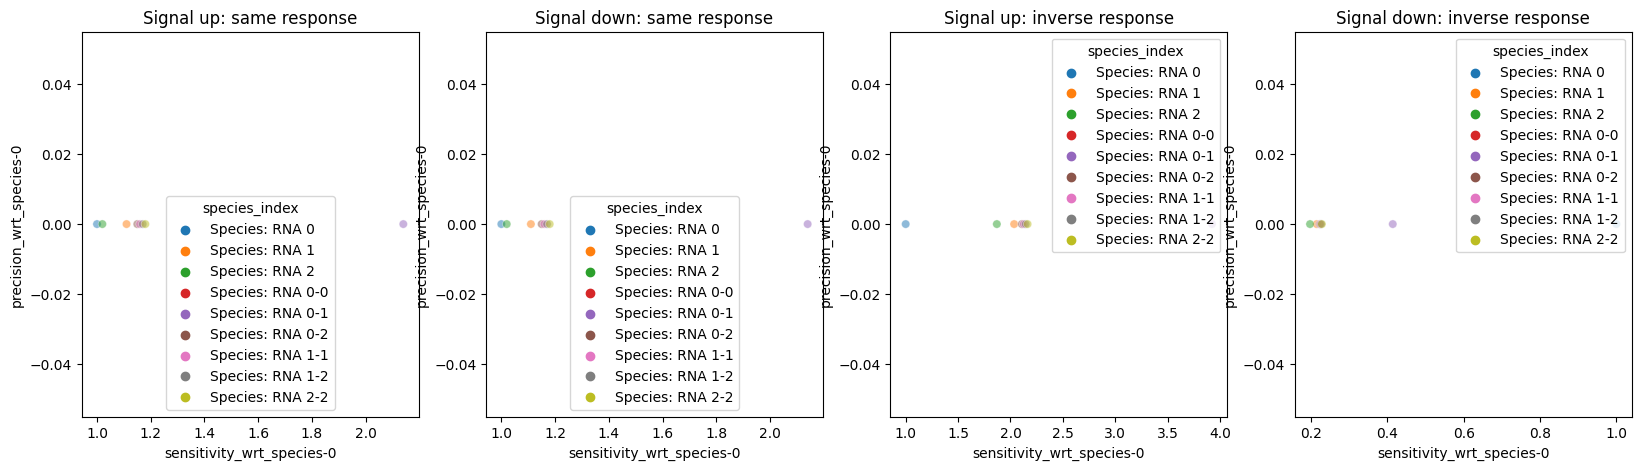

In [19]:
plt.figure(figsize=(20,5))
for i in range(batch_data.shape[0]):
    ax = plt.subplot(1,4,i+1)
    sns.scatterplot(analytics_df[analytics_df['data_index'] == i], 
                    x='sensitivity_wrt_species-0', y='precision_wrt_species-0',
                    hue='species_index', alpha=0.5)
    plt.title(analytics_df[analytics_df['data_index'] == i]['data_category'].unique()[0])

As expected, the sensitivity and precision for the signal responses are the same whether the signal input and its responses are falling or rising. The inverse case, where the signal response goes in the opposite direction of the signal, will necessariyl be different and look somewhat like flipped images of each other. The exact numbers of the signal responses have not been designed for this to be perfect, but the consistency of the non-signal species between all of the graphs shows that these analytics are indeed coherent.

Next: Overshoot and time response. These will be as accurate as the resolution of the supplied time axis.

Plot response times properly.

Signal time:  50.0
Expected overshoots:  [ 0 10  0  0  0 10 10 10 10]
Expected response times:  {0: 0, 1: 6.0, 2: 2, 3: inf, 4: 9.0, 5: 10.0, 6: 11.0, 7: 12.0, 8: 13.0}
Expected Lags          :  {0: 0, 1: 6.0, 2: 2, 3: inf, 4: 9.0, 5: 10.0, 6: 11.0, 7: 12.0, 8: 13.0}
Actual response times:  {0: 0.0, 1: 6.0, 2: 2.0, 3: inf, 4: 9.0, 5: 10.0, 6: 11.0, 7: 12.0, 8: 13.0}


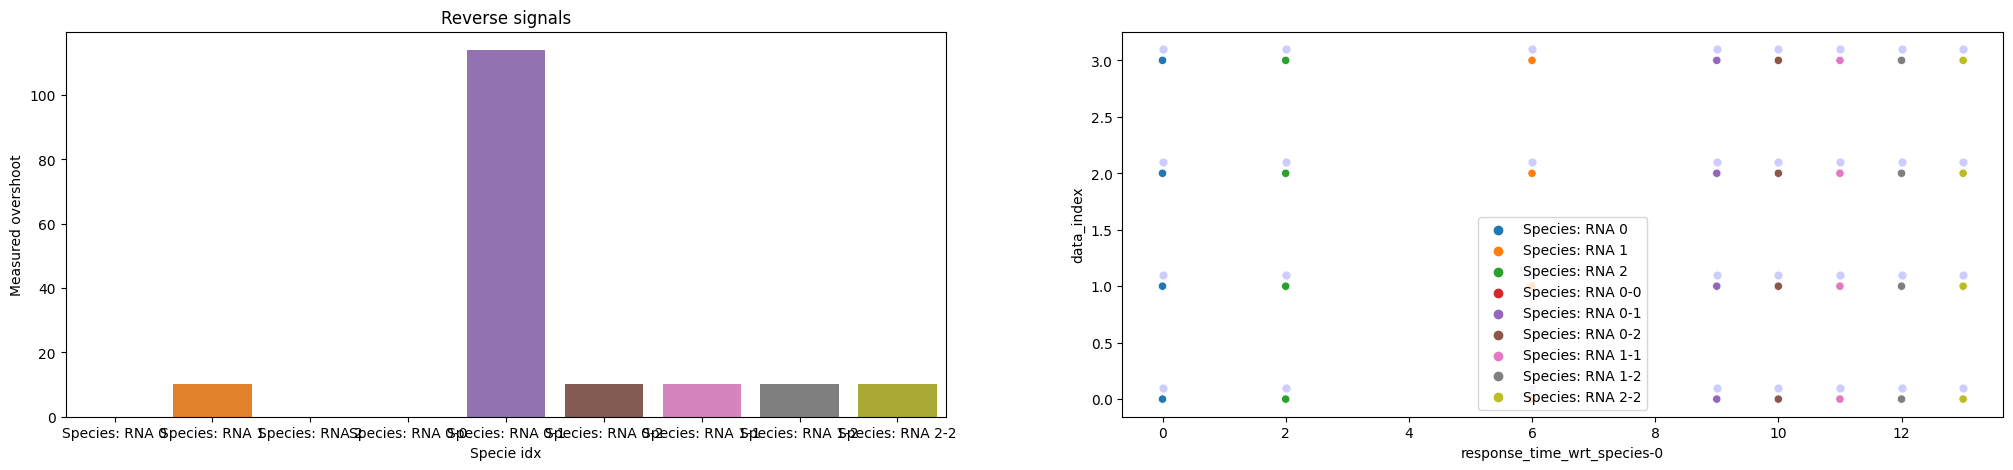

In [20]:
plt.figure(figsize=(25,5))
ax = plt.subplot(1,2,1)
# sns.barplot(analytics_df, x='species_index', y='overshoot', alpha=0.5)
sns.barplot(analytics_df[(analytics_df['data_index'] == 1) | (analytics_df['data_index'] == 3)], x='species_index', y='overshoot')
plt.title('Reverse signals')
plt.xlabel('Specie idx')
plt.ylabel('Measured overshoot')

ax = plt.subplot(1,2,2)
sns.scatterplot(analytics_df, x='response_time_wrt_species-0', y='data_index', hue='species_index')

rts = {i: overshoot/2 + i for i in list(np.arange(len(med_model.species))) if i not in [0, 2, 3]}
rts.update({0: 0, 2: 2, 3: np.inf})
sns.scatterplot(x=np.repeat(np.expand_dims(np.array(sorted(rts.values())), axis=0), repeats=4, axis=0).flatten(), y=analytics_df['data_index'] + 0.1, color='b', alpha=0.2)

print('Signal time: ', t_sig)
print('Expected overshoots: ', data.max(axis=1) - data[:, -1])
print('Expected response times: ', dict(sorted(rts.items())))
print('Expected Lags          : ', {i: l for i, l in enumerate(lags)})
print('Actual response times: ', analytics_df[analytics_df['data_index'] == 0]['response_time_wrt_species-0'].to_dict())

## Test response time more thoroughly

We will now construct more fake signals - this time with a soft activation shape to demonstrate how the response time is calculated for continuous functions. In this case, the signal is still a step function, while the responses are all sigmoid functions.

In [ ]:

sigmoidal = 1 / (1 + np.exp(-0.5 * (t - 30)))
t_sig_new = 10
signal = np.expand_dims(SignalFuncs.step_function_integrated(t, t_sig_new, target=4), axis=0)

batch_sigmoid = np.expand_dims(sigmoidal, axis=0) * np.expand_dims(np.arange(len(med_model.species) - 1), axis=1)
batch_sigmoid = np.expand_dims(np.concatenate([signal, batch_sigmoid], axis=0), axis=0) + 0.1
batch_sigmoid_ref = batch_sigmoid * 2

vmap_gen_analytics = jax.vmap(partial(generate_analytics, time=t, labels=list(med_model.species),
                                      signal_onehot=signal_onehot,
                                      signal_time=t_sig_new))
vv = vmap_gen_analytics(batch_sigmoid, ref_circuit_data=batch_sigmoid_ref)
analytics = {k: np.array(v) for k, v in vv.items()}

analytics['species_index'] = analytics_df['species_index'].values[:len(med_model.species)]

In [ ]:


def get_step_response_times(data, t, steady_states, deriv, signal_time: int):
    """ Assumes that data starts pre-perturbation, but after an initial steady state 
    has been reached. """

    t_expanded = t[:data.shape[-1]] * jnp.ones_like(steady_states)
    margin_stst = 0.001
    is_data_outside_stst = (data > (steady_states + steady_states * margin_stst)
                            ) | (data < (steady_states - steady_states * margin_stst))

    # 1. Get zero derivative within margin
    fmargin = 0.01
    fm = jnp.expand_dims(jnp.max(deriv, axis=1) * fmargin, axis=1)
    zd = (deriv <= fm) & (deriv >= -fm)  # This is just dx/dt == 0

    # 2. Find start time of signal change
    t0 = signal_time

    # 3. Get the time all species first start to change where the derivative is not zero
    #    If tstart is equal to 0, it means the species did not change after the signal
    tstart = t * ((zd == False) & (t_expanded >= t0)).astype(int)
    tstart = jnp.where(tstart == 0, np.inf, tstart)
    tstart = jnp.min(tstart, axis = 1)

    # 4. Stop measuring response time where the species is within the
    # steady state margin and has a zero derivative after its start time
    idxs_first_zd_after_signal = jnp.argmax(
        (t_expanded >= jnp.expand_dims(tstart, axis=1)) * (is_data_outside_stst == False), axis=1)
        # ((t_expanded * zd) >= jnp.expand_dims(tstart, axis=1)) * (is_data_outside_stst == False), axis=1)

    argmax_workaround = jnp.ones_like(
        steady_states) * jnp.arange(len(t)) == jnp.expand_dims(idxs_first_zd_after_signal - 1, axis=1)
    tstop = jnp.where(jnp.max(t_expanded * argmax_workaround, axis=1) != 0,
                        jnp.max(t_expanded * argmax_workaround, axis=1), tstart)

    response_times = jnp.where(
        tstart != 0,
        tstop - t0,
        np.inf
    )

    if response_times.ndim == 1:
        return jnp.expand_dims(response_times, axis=1)
    return response_times


Array([[ 0. ],
       [ inf],
       [33.6],
       [33.7],
       [33.7],
       [33.7],
       [33.7],
       [33.7],
       [33.7]], dtype=float32)

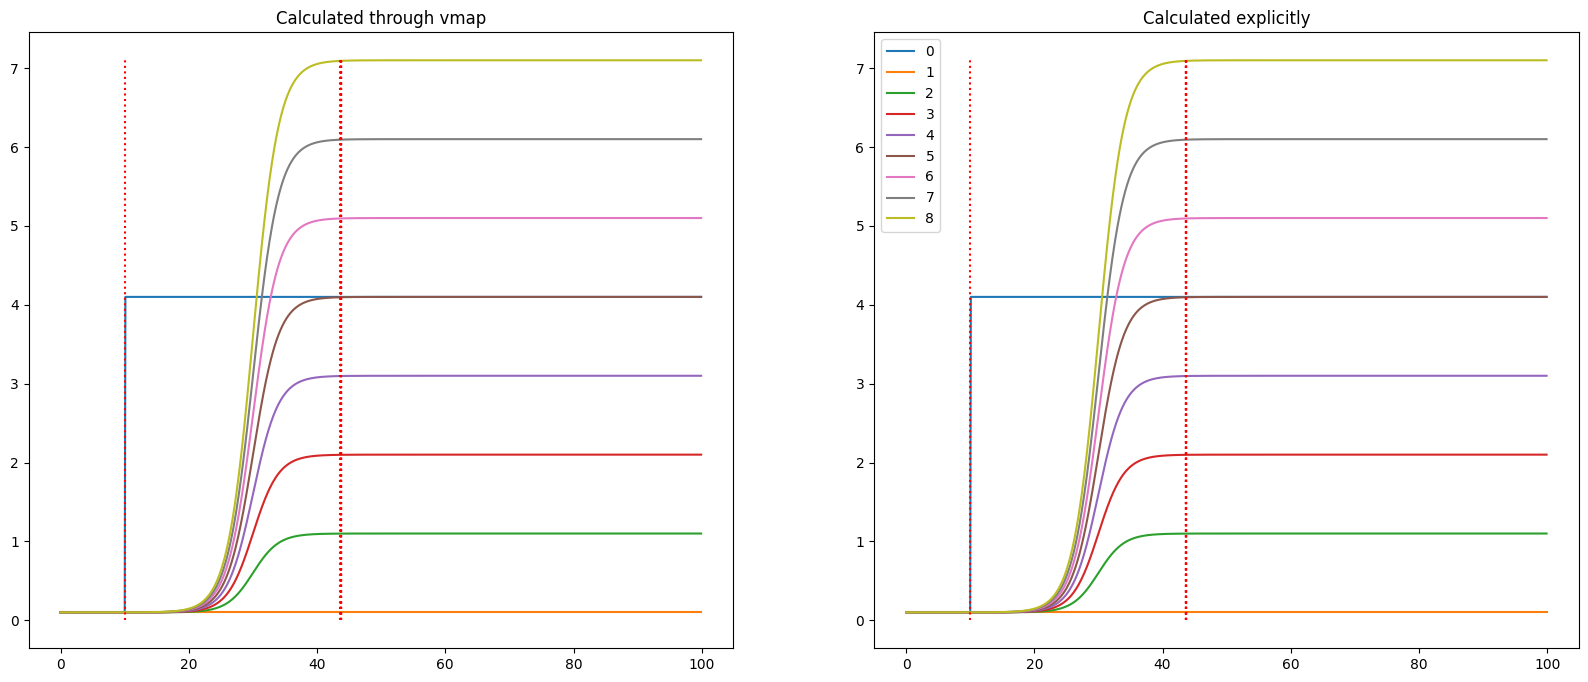

In [ ]:
plt.figure(figsize=(20, 8))
ax = plt.subplot(1,2,1)
plt.title('Calculated through vmap')
plt.plot(t, batch_sigmoid[0].T)
# plt.plot((np.ones((len(t), 1)) * np.expand_dims(response_times.squeeze() + t_sig_new, axis=0)), np.linspace(0, np.max(batch_sigmoid), len(t)), 'r:')
plt.plot((np.ones((len(t), 1)) * np.expand_dims(analytics['response_time_wrt_species-0'].squeeze() + t_sig_new, axis=0)), np.linspace(0, np.max(batch_sigmoid), len(t)), 'r:')
ax = plt.subplot(1,2,2)
plt.title('Calculated explicitly')
rs = get_step_response_times(batch_sigmoid[0], t, batch_sigmoid[0][:, [-1]], np.gradient(batch_sigmoid[0])[1], signal_time=t_sig_new)
plt.plot(t, batch_sigmoid[0].T)
plt.plot((np.ones((len(t), 1)) * np.expand_dims(rs.squeeze() + t_sig_new, axis=0)), np.linspace(0, np.max(batch_sigmoid), len(t)), 'r:')

plt.legend(np.arange(9))

rs

Looking under the hood of the response time function:

Array([ 0.,  6.,  2., inf,  9., 10., 11., 12., 13.], dtype=float32)

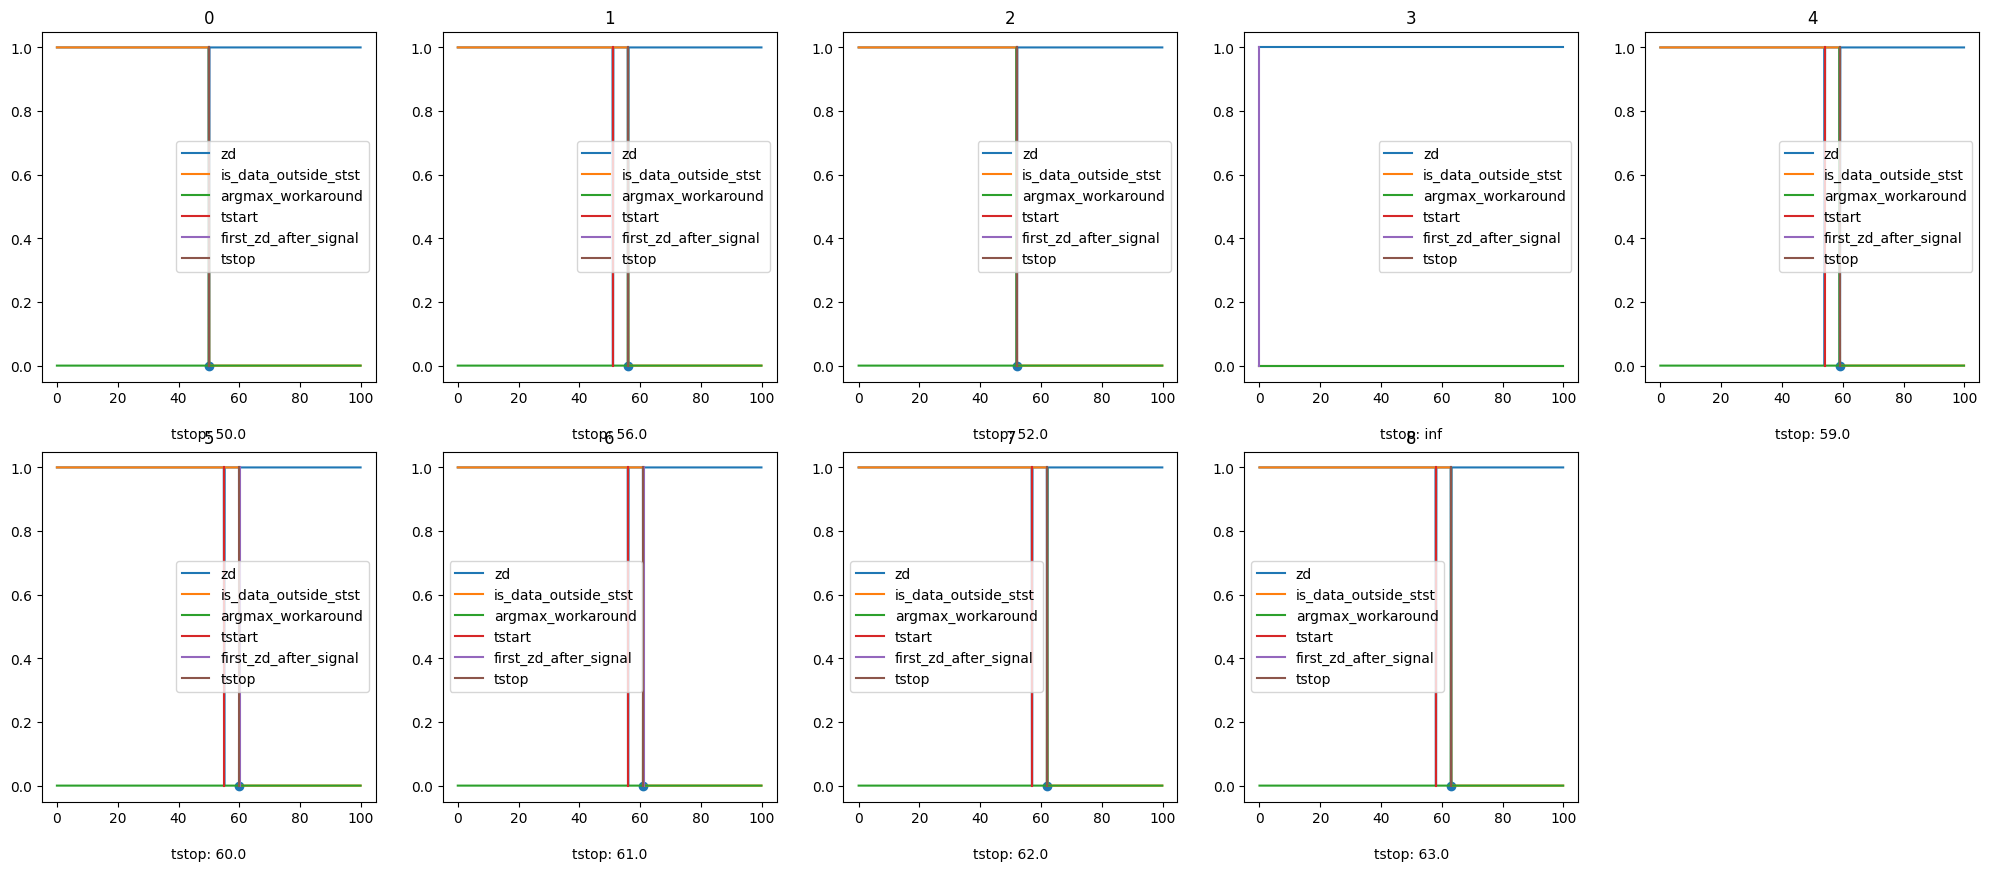

In [ ]:
b = batch_data[0]
data, t, steady_states, deriv, signal_time = b, t, b[:, [-1]], np.gradient(b)[1], t_sig
# data, t, steady_states, deriv, signal_time = batch_sigmoid[0], t, batch_sigmoid[0][:, [-1]], np.gradient(batch_sigmoid[0])[1], t_sig_new

## Start of response time function
t_expanded = t[:data.shape[-1]] * jnp.ones_like(steady_states)
margin_stst = 0.001
is_data_outside_stst = (data > (steady_states + steady_states * margin_stst)
                        ) | (data < (steady_states - steady_states * margin_stst))

# 1. Get zero derivative within margin
fmargin = 0.01
fm = jnp.expand_dims(jnp.max(deriv, axis=1) * fmargin, axis=1)
zd = (deriv <= fm) & (deriv >= -fm)  # This is just dx/dt == 0

# 2. Find start time of signal change
t0 = signal_time

# 3. Get the time all species first start to change where the derivative is not zero
#    If tstart is equal to 0, it means the species did not change after the signal
tstart = t * ((zd == False) & (t_expanded >= t0)).astype(int)
tstart = jnp.where(tstart == 0, np.inf, tstart)
tstart = jnp.min(tstart, axis = 1)

# 4. Stop measuring response time where the species is within the
# steady state margin and has a zero derivative after its start time
idxs_first_zd_after_signal = jnp.argmax(
    (t_expanded >= jnp.expand_dims(tstart, axis=1)) * (is_data_outside_stst == False), axis=1)
    # ((t_expanded * zd) >= jnp.expand_dims(tstart, axis=1)) * (is_data_outside_stst == False), axis=1)

argmax_workaround = jnp.ones_like(
    steady_states) * jnp.arange(len(t)) == jnp.expand_dims(idxs_first_zd_after_signal - 1, axis=1)
tstop = jnp.where(jnp.max(t_expanded * argmax_workaround, axis=1) != 0,
                    jnp.max(t_expanded * argmax_workaround, axis=1), tstart)

response_times = jnp.where(
    tstart != 0,
    tstop - t0,
    np.inf
)

plt.figure(figsize=(25, 10))
for i, s in enumerate(med_model.species):
    ax = plt.subplot(2, 5, i+1)
    plt.plot(t, zd[i, :].T)
    plt.plot(t, is_data_outside_stst[i, :].T)
    plt.plot(t, argmax_workaround[i, :].T)
    plt.plot(tstart[i] * np.ones(10), np.arange(10) * 1/9)
    plt.plot(t[idxs_first_zd_after_signal][i] * np.ones(10), np.arange(10) * 1/9)
    plt.plot(tstop[i] * np.ones(10), np.arange(10) * 1/9)
    plt.scatter(response_times[i] + t_sig, 0)
    # plt.plot(t, b[i] / b[i].max())
    plt.legend(['zd', 'is_data_outside_stst', 'argmax_workaround', 'tstart', 'first_zd_after_signal', 'tstop'])
    # stst = (b[i] / b[i].max())[-1]
    # plt.plot(t, np.ones_like(t) * (stst + stst * margin_stst), 'r')
    # plt.plot(t, np.ones_like(t) * (stst - stst * margin_stst), 'r')
    # plt.plot(t, fm[i, :].T)
    plt.title(i)
    
    plt.xlabel('\ntstop: ' + str(tstop[i]))
    
response_times

## Sensitivity?

In [ ]:
analytics_df2 = pd.DataFrame({k: v.squeeze() for k, v in analytics.items() if k in analytics_df.columns})

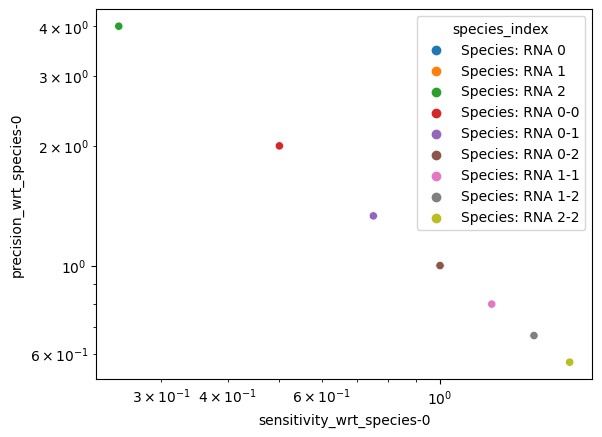

In [ ]:
sns.scatterplot(analytics_df2, x='sensitivity_wrt_species-0', y='precision_wrt_species-0', hue='species_index', alpha=1)
plt.xscale('log')
plt.yscale('log')

In [ ]:
analytics_df2[['precision_wrt_species-0', 'sensitivity_wrt_species-0']]

,precision_wrt_species-0,sensitivity_wrt_species-0
0,1.000000,1.000000
1,inf,0.000000
2,4.000013,0.249999
3,2.000013,0.499997
4,1.333346,0.749993
5,1.000013,0.999987
6,0.800012,1.249981
7,0.666679,1.499972
8,0.571441,1.749962
